# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import random

# Check if we have CUDA support

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Total memory: 6.0 GB


# Dataset

## Load dataset from CSV

In [3]:
# Pathfile of actual CSV dataset
file_path = 'Dataset/Combined_features.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Separate features and class
features = df.iloc[:, :-1]  # Select all columns except the last one
target = df.iloc[:, -1]     # Select only the last column

# Display the first few rows of the DataFrame to inspect the data
print("Labels example: \n", target.head(2))
features.head(2)

Labels example: 
 0    0.0
1    0.0
Name: Class, dtype: float64


,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
0,7493.390318,7.136456,7493.390318,478.029614,3.181524e+10,7.136456,478.502127,2.436395e+07,3.617252e+08,6.696118e+11
1,7465.559631,6.832010,7465.559631,477.358359,3.178214e+10,6.832010,473.332925,2.373346e+07,3.518449e+08,6.688907e+11


## Plot a simple feature

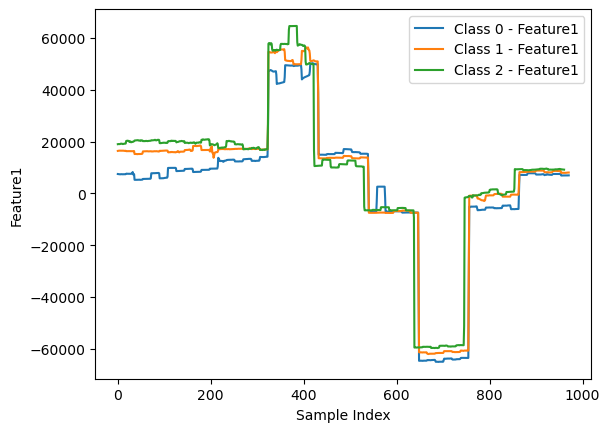

In [6]:
# Plotting example
feature_column = 'Feature1'

# Filter the DataFrame for rows where 'Class' is equal to 0
class_0_data = df[df.iloc[:, -1] == 0].reset_index(drop=True)
class_1_data = df[df.iloc[:, -1] == 1].reset_index(drop=True)
class_2_data = df[df.iloc[:, -1] == 2].reset_index(drop=True)

# Plot the selected feature for class 0 and class 1 on the same plot
plt.plot(class_0_data[feature_column], label=f'Class 0 - {feature_column}', linestyle='-')
plt.plot(class_1_data[feature_column], label=f'Class 1 - {feature_column}', linestyle='-')
plt.plot(class_2_data[feature_column], label=f'Class 2 - {feature_column}', linestyle='-')

plt.xlabel('Sample Index')
plt.ylabel(feature_column)
plt.legend()
plt.show()

## Get the actual Dataloader

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Features (until last column)
        features = torch.tensor(self.data[idx, :-1], dtype=torch.float32)

        # Label (last column)
        label = torch.tensor(self.data[idx, -1], dtype=torch.float32)

        return features, label

In [8]:
scaler = MinMaxScaler()
labels = df.iloc[:, -1]

df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]))

finalDf = pd.concat([df_scaled, labels], axis=1)
finalDf = finalDf.dropna()  # Remove rows with NaN values

assert not finalDf.isna().any().any(), "finalDf contains NaN values"

train_df, test_df = train_test_split(finalDf, test_size=0.2, random_state=2057231)

# Create custom datasets and data loaders
train_dataset = CustomDataset(pd.DataFrame(train_df))
test_dataset = CustomDataset(pd.DataFrame(test_df))

batch_size = 8  # Adjust as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")
print("------------------------------------------------------")
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")
print("------------------------------------------------------")
batch = next(iter(train_loader))
print(f"Shape of batch (X): {batch[0].shape}")
print(f"Shape of batch (y): {batch[1].shape}")

Number of samples in train dataset: 3084
Number of samples in test dataset: 771
------------------------------------------------------
Number of batches in train loader: 386
Number of batches in test loader: 97
------------------------------------------------------
Shape of batch (X): torch.Size([8, 10])
Shape of batch (y): torch.Size([8])


# Model

In [19]:
class CVAE(nn.Module):
    def __init__(self, num_features, latent_dim, output_dim, condition_dim):
        super(CVAE, self).__init__()

        # Encoder
        #self.fc1 = nn.Linear(num_features + condition_dim, 512)
        self.fc1 = nn.Linear(num_features, 64, device=device)
        self.fc2 = nn.Linear(64, 32, device=device)

        self.fc_mu = nn.Linear(32, latent_dim, device=device)
        self.fc_logvar = nn.Linear(32, latent_dim, device=device)

        # Decoder
        #.fc3 = nn.Linear(latent_dim + condition_dim, 256)
        self.fc3 = nn.Linear(latent_dim, 32, device=device)
        self.fc4 = nn.Linear(32, 64, device=device)

        self.fc_output = nn.Linear(64, output_dim, device=device)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc_mu(x), self.fc_logvar(x)

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc_output(z))

    # Take the mean (mu - μ) and log-variance (log(2)log(σ2)) produced by the Encoder 
    # and generates a latent code z using the reparameterization trick.
    # This process ensures that the sampling operation is differentiable,
    # enabling the use of backpropagation during training.
    def reparameterize(self, mu, logvar):
        # The standard deviation (std) is calculated as the 
        # exponential of half of the log-variance.
        # This ensures that std is positive.
        std = torch.exp(0.5 * logvar)

        # Generates random noise with the same shape as the computed standard deviation.
        # This noise is sampled from a normal distribution with mean 0 and standard deviation 1.
        eps = torch.randn_like(std)
        return mu + eps * std # μ + σ ⊙ ϵ

    def forward(self, x, condition=None):
        #x = torch.cat([x, condition], dim=1)    # Add the condition to Encoder - CVAE ---> TODO
        
        mu, logvar = self.encode(x)             # Encoding

        z = self.reparameterize(mu, logvar)     # Re-parametrization | Latent variable

        #z = torch.cat([z, condition], dim=1)    # Add the condition to Decoder - CVAE ---> TODO
        reconstructed_x = self.decode(z)        # Decoding
        return reconstructed_x, mu, logvar

In [20]:
num_features = 10  # Number of features in the CSV
latent_dim = 5  # Latent space dimension
output_dim = 10  # Output dimension (same as input for reconstruction)
condition_dim = 1  # Dimension of the conditional variable (4 classes)

cvae = CVAE(num_features, latent_dim, output_dim, condition_dim)
cvae = cvae.to(device=device)
print(cvae)

CVAE(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc_mu): Linear(in_features=32, out_features=5, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=10, bias=True)
)


In [21]:
# Example usage
num_epochs = 50

# Define your loss function and optimizer
criterion = nn.MSELoss()  # You can choose a different loss function based on your task

# Define your optimizer
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)  # You can adjust the learning rate based on your needs

# Training loop
for epoch in tqdm(range(num_epochs), desc=F"Epochs (Train)", leave=True):

    # Train CVAE
    cvae.train()

    losses = []  # Store the loss of each batch in this list

    for i, (x, labels) in enumerate(train_loader):

        # We need to move to the GPU
        x = x.to(device=device)
        labels = labels.to(device=device)

        # Forward pass
        reconstructed_data, mu, logvar = cvae(x, None)

        # Assuming reconstructed_x is the output of your CVAE, input_x is the input data
        reconstruction_loss = criterion(reconstructed_data, x)

        # KL Divergence
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Compute the mean and standard deviation of the losses
    mean_loss = np.mean(losses)
    std_loss = np.std(losses)

    print(f"Epoch {epoch} | Mean Loss = {mean_loss:.3f} | Std Loss = {std_loss:.3f}")

Epochs (Train):   0%|          | 0/50 [00:00<?, ?it/s]

Epochs (Train):   2%|▏         | 1/50 [00:03<02:33,  3.12s/it]

Epoch 0 | Mean Loss = 0.039 | Std Loss = 0.079


Epochs (Train):   4%|▍         | 2/50 [00:06<02:24,  3.02s/it]

Epoch 1 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):   6%|▌         | 3/50 [00:08<02:19,  2.97s/it]

Epoch 2 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):   8%|▊         | 4/50 [00:11<02:15,  2.94s/it]

Epoch 3 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  10%|█         | 5/50 [00:14<02:10,  2.90s/it]

Epoch 4 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  12%|█▏        | 6/50 [00:17<02:06,  2.88s/it]

Epoch 5 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  14%|█▍        | 7/50 [00:20<02:04,  2.89s/it]

Epoch 6 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  16%|█▌        | 8/50 [00:23<02:01,  2.89s/it]

Epoch 7 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  18%|█▊        | 9/50 [00:26<01:59,  2.91s/it]

Epoch 8 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  20%|██        | 10/50 [00:29<01:56,  2.91s/it]

Epoch 9 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  22%|██▏       | 11/50 [00:32<01:53,  2.91s/it]

Epoch 10 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  24%|██▍       | 12/50 [00:35<01:50,  2.90s/it]

Epoch 11 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  26%|██▌       | 13/50 [00:37<01:47,  2.91s/it]

Epoch 12 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  28%|██▊       | 14/50 [00:40<01:45,  2.94s/it]

Epoch 13 | Mean Loss = 0.014 | Std Loss = 0.009


Epochs (Train):  30%|███       | 15/50 [00:43<01:43,  2.97s/it]

Epoch 14 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  32%|███▏      | 16/50 [00:46<01:40,  2.97s/it]

Epoch 15 | Mean Loss = 0.014 | Std Loss = 0.009


Epochs (Train):  34%|███▍      | 17/50 [00:49<01:36,  2.93s/it]

Epoch 16 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  36%|███▌      | 18/50 [00:52<01:33,  2.93s/it]

Epoch 17 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  38%|███▊      | 19/50 [00:55<01:30,  2.91s/it]

Epoch 18 | Mean Loss = 0.014 | Std Loss = 0.009


Epochs (Train):  40%|████      | 20/50 [00:58<01:26,  2.89s/it]

Epoch 19 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  42%|████▏     | 21/50 [01:01<01:23,  2.88s/it]

Epoch 20 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  44%|████▍     | 22/50 [01:04<01:21,  2.89s/it]

Epoch 21 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  46%|████▌     | 23/50 [01:07<01:17,  2.87s/it]

Epoch 22 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  48%|████▊     | 24/50 [01:10<01:16,  2.93s/it]

Epoch 23 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  50%|█████     | 25/50 [01:13<01:13,  2.93s/it]

Epoch 24 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  52%|█████▏    | 26/50 [01:16<01:10,  2.95s/it]

Epoch 25 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  54%|█████▍    | 27/50 [01:18<01:07,  2.94s/it]

Epoch 26 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  56%|█████▌    | 28/50 [01:21<01:04,  2.94s/it]

Epoch 27 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  58%|█████▊    | 29/50 [01:24<01:01,  2.93s/it]

Epoch 28 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  60%|██████    | 30/50 [01:27<00:58,  2.94s/it]

Epoch 29 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  62%|██████▏   | 31/50 [01:30<00:56,  2.96s/it]

Epoch 30 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  64%|██████▍   | 32/50 [01:33<00:53,  2.95s/it]

Epoch 31 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  66%|██████▌   | 33/50 [01:36<00:50,  2.95s/it]

Epoch 32 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  68%|██████▊   | 34/50 [01:39<00:47,  2.95s/it]

Epoch 33 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  70%|███████   | 35/50 [01:42<00:43,  2.93s/it]

Epoch 34 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  72%|███████▏  | 36/50 [01:45<00:41,  2.96s/it]

Epoch 35 | Mean Loss = 0.014 | Std Loss = 0.009


Epochs (Train):  74%|███████▍  | 37/50 [01:48<00:38,  2.96s/it]

Epoch 36 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  76%|███████▌  | 38/50 [01:51<00:35,  2.99s/it]

Epoch 37 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  78%|███████▊  | 39/50 [01:54<00:32,  2.96s/it]

Epoch 38 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  80%|████████  | 40/50 [01:57<00:29,  2.92s/it]

Epoch 39 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  82%|████████▏ | 41/50 [01:59<00:24,  2.73s/it]

Epoch 40 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  84%|████████▍ | 42/50 [02:01<00:20,  2.59s/it]

Epoch 41 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  86%|████████▌ | 43/50 [02:03<00:17,  2.44s/it]

Epoch 42 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  88%|████████▊ | 44/50 [02:05<00:14,  2.34s/it]

Epoch 43 | Mean Loss = 0.014 | Std Loss = 0.009


Epochs (Train):  90%|█████████ | 45/50 [02:08<00:11,  2.25s/it]

Epoch 44 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  92%|█████████▏| 46/50 [02:10<00:08,  2.21s/it]

Epoch 45 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  94%|█████████▍| 47/50 [02:12<00:06,  2.20s/it]

Epoch 46 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  96%|█████████▌| 48/50 [02:14<00:04,  2.17s/it]

Epoch 47 | Mean Loss = 0.014 | Std Loss = 0.008


Epochs (Train):  98%|█████████▊| 49/50 [02:16<00:02,  2.13s/it]

Epoch 48 | Mean Loss = 0.014 | Std Loss = 0.009


Epochs (Train): 100%|██████████| 50/50 [02:18<00:00,  2.77s/it]

Epoch 49 | Mean Loss = 0.014 | Std Loss = 0.008


Generated samples:
	tensor([[0.5362, 0.4769, 0.5348, 0.0137, 0.1165, 0.4774, 0.0756, 0.0205, 0.0161,
         0.1078]], device='cuda:0') | Shape: torch.Size([1, 10])
True samples:
	tensor([[0.5568, 0.4824, 0.5568, 0.0070, 0.0647, 0.4824, 0.0438, 0.0024, 0.0014,
         0.0578]], device='cuda:0') | Shape: torch.Size([1, 10])


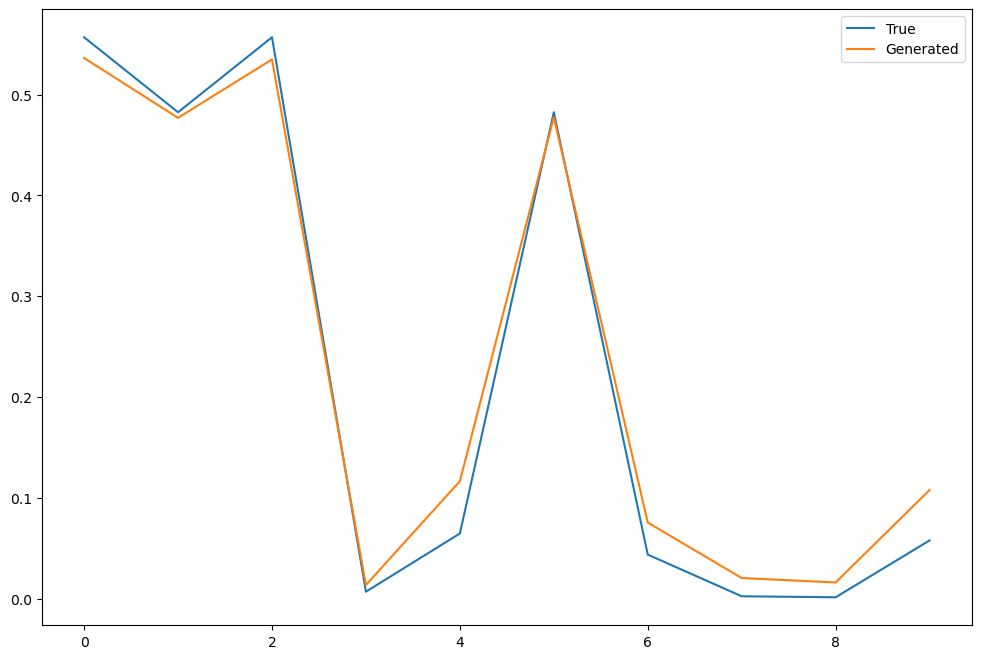

In [95]:
# Assuming cvae is your trained CVAE model
# Assuming latent_dim is the dimensionality of the latent space
num_samples = 1
cvae.eval()
randomNoise = False

outputList = []
outputListTrue = []

if(randomNoise):
    with torch.no_grad():
        # Generate random latent vectors from a normal distribution
        y_true = torch.rand(1, 10, device=device)

        # Repeat the condition tensor for each generated sample
        # Pass the latent vectors through the decoder
        generated_samples, _, _ = cvae(y_true)

        y = generated_samples.detach().cpu().numpy()[0, :]
        y_true = y_true.detach().cpu().numpy()[0, :]
else: # Test loader
    with torch.no_grad():
        test_iter = iter(test_loader)
        random_batch_idx = random.randint(0, len(test_loader) - 1)
        for batch_idx, (x, _) in enumerate(test_loader):
            if batch_idx == random_batch_idx:
                x = x.to(device=device)
                x = x[0, :].unsqueeze(0)  # Get just one sample and pass it to the network
                x_hat, _, _ = cvae(x)
                outputList.append(x_hat)
                outputListTrue.append(x)
                break

        # Example usage:
        generated_samples_torch = torch.vstack(outputList)
        true_samples_torch = torch.vstack(outputListTrue)
        print(F"Generated samples:\n\t{generated_samples_torch} | Shape: {generated_samples_torch.shape}")
        print(F"True samples:\n\t{true_samples_torch} | Shape: {true_samples_torch.shape}")

        # We take the 6th sample from the generated samples and print all the channels
        y = generated_samples_torch.detach().cpu().numpy()[0, :]
        y_true = true_samples_torch.detach().cpu().numpy()[0, :]

plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y, label='Generated')
plt.legend()
plt.show()